# <u> <center> Restaurant Marketing Campaign Analysis </center> </u> 

##  <center> Data Snapshot</center>

In [1]:
suppressMessages(library(dplyr))
setwd("C:/eLearning/Interview-prep/Uber/")

data = read.csv("food_train.csv", header=T)
glimpse(data)

Warning message:
"package 'dplyr' was built under R version 3.4.4"

Observations: 548
Variables: 7
$ MarketID         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ MarketSize       <fct> Medium, Medium, Medium, Medium, Medium, Medium, Me...
$ LocationID       <int> 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5,...
$ AgeOfStore       <int> 4, 4, 4, 4, 5, 5, 5, 5, 12, 12, 12, 12, 1, 1, 1, 1...
$ Promotion        <int> 3, 3, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,...
$ Week             <int> 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1,...
$ SalesInThousands <dbl> 33.73, 35.67, 29.03, 39.25, 27.81, 34.67, 27.98, 2...


## What is the data all about

* **Scenario:** A company plans to launch a new product. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new productt is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new product are recorded for the first four weeks.


* **Variables:**
    1. Market ID - Unique identifier for the market
    2. Market Size - Size of the selected market (Small, Medium, Large)
    3. Location ID - Unique identifier for store location
    4. AgeOfStore - Age of Store in years
    5. Promotion - The ID of the promotion tested (1,2,3)
    6. week - One of the four weeks promotions were run (1,2,3,4)
    7. SalesInThousands - Sales amount for a particular Location ID - Promotion and week.

In [2]:
head(data)

MarketID,MarketSize,LocationID,AgeOfStore,Promotion,Week,SalesInThousands
1,Medium,1,4,3,1,33.73
1,Medium,1,4,3,2,35.67
1,Medium,1,4,3,3,29.03
1,Medium,1,4,3,4,39.25
1,Medium,2,5,2,1,27.81
1,Medium,2,5,2,2,34.67


## Business objective

* Identify the factors affecting the variation in Sales.


### 1. Linear Regression

* Let us use linear regression to see what is causing the variation in Sales
* **Steps**:
    * One hot encode the categorical features.
    * Variable selection amongst 150 odd features.
    * Multicollinearity and Influential observation diagnostics.
    * Analyze the linearity assumptions.
    * Report the results.


* Calling required packages

In [3]:
suppressMessages(library(ggplot2))
suppressMessages(library(recipes))
suppressMessages(library(caret))
suppressMessages(library(rsample))
suppressMessages(library(leaps))
suppressMessages(library(MASS))

Warning message:
"package 'ggplot2' was built under R version 3.4.4"Warning message:
"package 'recipes' was built under R version 3.4.4"Warning message:
"package 'broom' was built under R version 3.4.4"Warning message:
"package 'rsample' was built under R version 3.4.4"Warning message:
"package 'tidyr' was built under R version 3.4.4"Warning message:
"package 'leaps' was built under R version 3.4.4"

### <u> <center> a. One hot encode the categorical features </center> </u>

In [4]:
cat_features <- c("MarketID", "MarketSize", "LocationID",
                  "Promotion", "Week")

# Convert all cat_features to factors
data[,cat_features] <- lapply(data[,cat_features] , factor)

# Split the data into train and test
train_test_split <- initial_split(data, prop = 0.8)
train_tbl <- training(train_test_split)
test_tbl  <- testing(train_test_split)


# Use recipies package to dummy all categorical features
rec_obj <- recipe(SalesInThousands~., data = train_tbl) %>%
  step_dummy(all_nominal(), -all_outcomes()) %>%
  prep(data = train_tbl)

# Extract new data
x_train_tbl <- bake(rec_obj, newdata = train_tbl)
x_test_tbl  <- bake(rec_obj, newdata = test_tbl)

head(x_train_tbl)

AgeOfStore,SalesInThousands,MarketID_X2,MarketID_X3,MarketID_X4,MarketID_X5,MarketID_X6,MarketID_X7,MarketID_X8,MarketID_X9,...,LocationID_X916,LocationID_X917,LocationID_X918,LocationID_X919,LocationID_X920,Promotion_X2,Promotion_X3,Week_X2,Week_X3,Week_X4
4,35.67,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,29.03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,39.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5,27.81,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,34.67,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5,27.98,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


### <u> <center> b. Variable Selection </center> </u>

In [5]:
dim(x_train_tbl)

[1] 439 154

* We have 153 features, many of which are dummy variables.
* We would want to reduce these features to ones which are the most important
* Doing variable selection using **stepAIC** function from the **MASS** package.
* **direction = "both"** indicates that both forward and backward selection will be performed and the model having the best AIC value will be selected

In [6]:
linear_model = lm(SalesInThousands~., data=x_train_tbl)

step_model_both = stepAIC(linear_model, direction = "both", 
                             trace = FALSE)

summary(step_model_both)


Call:
lm(formula = SalesInThousands ~ AgeOfStore + MarketID_X2 + MarketID_X3 + 
    MarketID_X4 + MarketID_X5 + MarketID_X6 + MarketID_X7 + MarketID_X8 + 
    MarketID_X9 + MarketID_X10 + LocationID_X2 + LocationID_X3 + 
    LocationID_X7 + LocationID_X9 + LocationID_X12 + LocationID_X13 + 
    LocationID_X101 + LocationID_X103 + LocationID_X104 + LocationID_X201 + 
    LocationID_X204 + LocationID_X205 + LocationID_X207 + LocationID_X210 + 
    LocationID_X212 + LocationID_X213 + LocationID_X214 + LocationID_X215 + 
    LocationID_X216 + LocationID_X217 + LocationID_X219 + LocationID_X221 + 
    LocationID_X301 + LocationID_X303 + LocationID_X305 + LocationID_X306 + 
    LocationID_X307 + LocationID_X308 + LocationID_X401 + LocationID_X402 + 
    LocationID_X404 + LocationID_X405 + LocationID_X406 + LocationID_X407 + 
    LocationID_X408 + LocationID_X411 + LocationID_X413 + LocationID_X414 + 
    LocationID_X501 + LocationID_X502 + LocationID_X503 + LocationID_X505 + 
    LocationID

* The above list shows all the features which were selected in the best linear regression model.
* Model has good Adj. R2 92.08% which means the variables we are using is explaining 92% of the variation in Sales. Next question is which variables and what values of those variables are making the most impact?
* Variables showing to be affecting Sales are **All Market IDs, few location IDs, Promotion X2 and X3** according to the t-Test for individual significance. 
* **MarketSize** dummy variables were thrown out of the model in variable selection which indicates MarketSize is not very related to the Sales, so we may want to reduce or eliminate its importance while making any product launch decisions.


* To check whether these results can indeed be trusted we will have to check the collinearity structure among features as well as influential observations.
* Also, the linearity assumptions.

### <u> <center> c. Checking collinearity and infulential observations </center> </u>

* Multicollinearity can affect linear regression results. Multicollinearity arises when predictors are correlated among themselves. There are two ways to test Multicollinearity, first we can check correlations amongst predictors or we can use VIF metric to quantify multicollinearity for each feature.
* Since we have a lot of dummy features, it is advised to use VIF than correlations because correlations of dummy variables are very sensitive. More on that in this SE post https://stats.stackexchange.com/questions/67309/how-to-test-for-multicollinearity-among-dummy-explanatory-variables
* Also let us check Influential observations using leverage and cooks distance

In [7]:
suppressMessages(library(car))

vif_step_both = car::vif(step_model_both)
summary(vif_step_both)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.041   1.163   1.325   1.799   1.647  10.306 

* Maximum VIF amongst all features is 3.688. A VIF of 5 indicates mild MColin and that of 10 indicates strong MColin.
* So no multicollinearity is present which is great news. This indicates our coefficients can be trusted upon till now.

* Now lets check leverage and cooks distance
* Leverage values greater than 3(m+1)/n are supposed to be a red flag. Here m = 45 and n = 439 so our cutoff is 0.307

In [8]:
lev = hat(model.matrix(step_model_both))
dim(x_train_tbl[lev > 0.307,])

[1] 124 154

**Leverage**

* Leverage gives us a measure of how a particularly far away is the value of a particular indepedent variables vector in its own space.
* We are getting 56 points which have a high leverage. Lets go ahead and check their influentiality (how much they change the regression equation) in order to see if we want to take action on them.
* Note that Influentiality measure **Cooks distance**  takes Leverage into account as well as a measure of outlierness of a row.
* Difference between leverage, outliers and influential observations is that leverage takes into account how far away a point is in Predictor space, outlier takes into account how far away a point is in Y-space and influentiality judges if leverage and outlierness together of points are affecting the regression equation.

**Influentiality - Cooks Distance**



In [9]:
cook = cooks.distance(step_model_both)
summary(cook)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
0.0000000 0.0001641 0.0009391 0.0029858 0.0034711 0.0321290         2 

* No point has a cooks distance above 0.1 which is our threshold.
* I calculated threshold using the formula **N/(N-k-1)** which equals 0.1. N = 439, k = 45.
* The idea for this threshold formula is explained in this post https://stats.stackexchange.com/questions/22161/how-to-read-cooks-distance-plots
* Since there is no influentiality of any observations, we can ignore the leverage for now.
* Also note that leverage formula takes into account the deviations from the mean of our features. In our dataset there are a lot of indicator features so they might be causing the leverages to inflate too but can't say for sure. Anyway, I have decided to move further since there is no influenciality.

### <u> <center> d. Checking regression assumptions </center> </u>

#### 1. Normal Probability Plot of Residuals

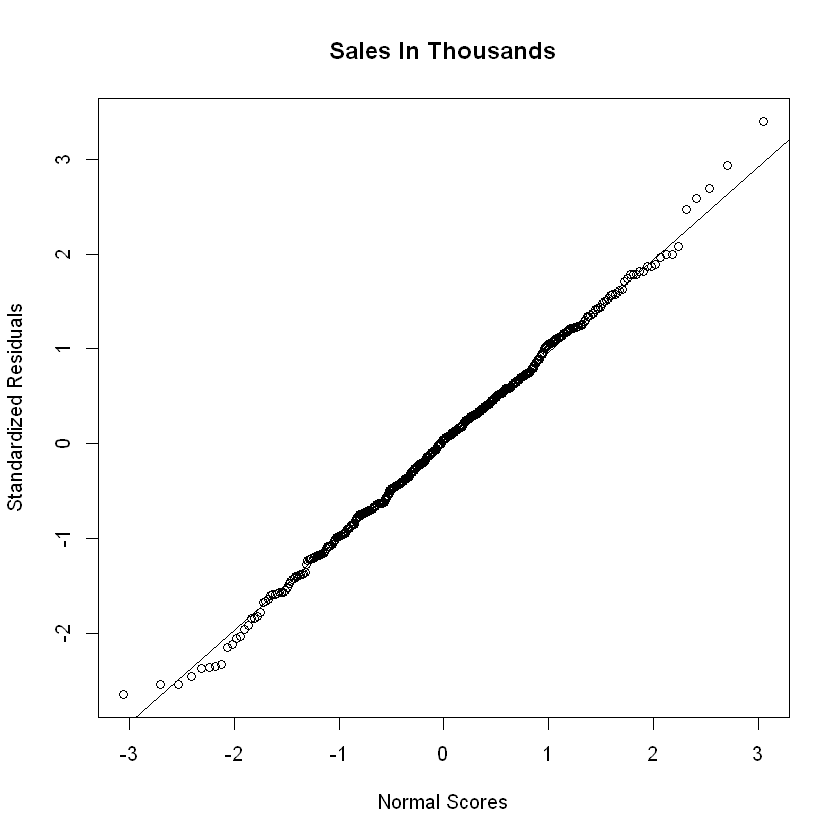

In [10]:
sales_stdres = rstandard(step_model_both)
qqnorm(sales_stdres, 
     ylab="Standardized Residuals", 
     xlab="Normal Scores", 
     main="Sales In Thousands") 
qqline(sales_stdres)

* The residuals look pretty normally distributed. Lets run an additional **Anderson-Darling test** on this data for which the null hypothesis is that the errors are normally distributed.

In [11]:
suppressMessages(library(nortest))
ad.test(sales_stdres)


	Anderson-Darling normality test

data:  sales_stdres
A = 0.18041, p-value = 0.915


* We can accept the Null hypothesis and conclude that there is normality in errors. So one assumption is satisfied.

#### 2. Scatterplot of Standardized residuals and fitted values

In [12]:
resid_fitted_plot_df <- data.frame(sales_stdres=sales_stdres,
                                   fitted=as.numeric(fitted(step_model_both)))
head(resid_fitted_plot_df)

sales_stdres,fitted
0.1758337,34.82708
-1.2092808,34.82708
0.9226274,34.82708
-0.4077312,29.54500
1.2043932,29.54500
-0.3677806,29.54500


Warning message:
"Removed 2 rows containing missing values (geom_point)."

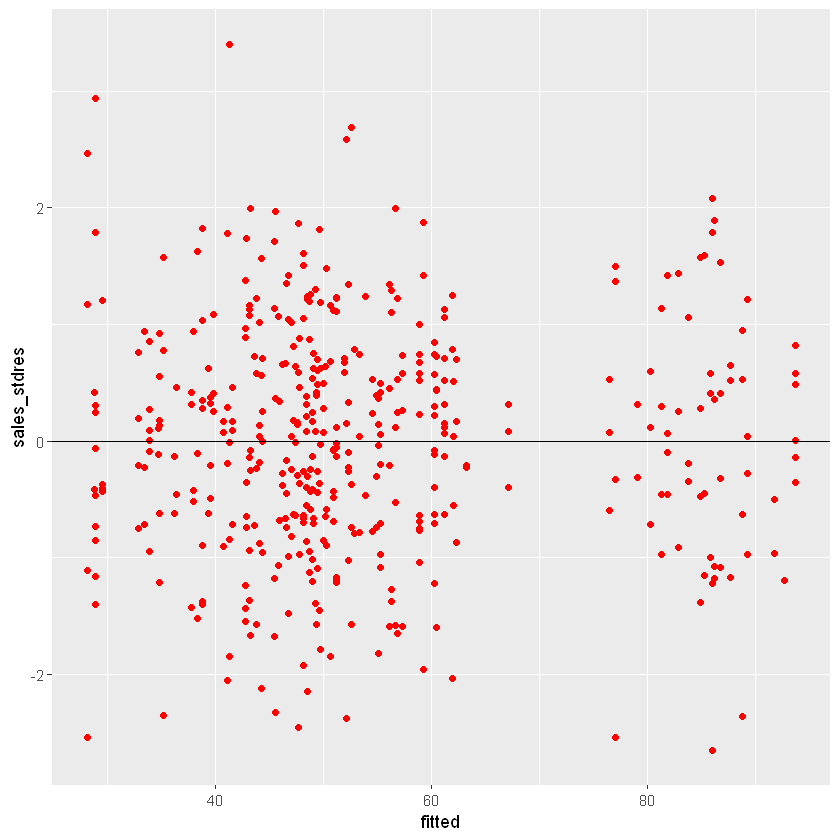

In [13]:
ggplot(data=resid_fitted_plot_df, aes(x=fitted, y=sales_stdres)) +
    geom_point(colour="red") + geom_hline(yintercept = 0)

* The plot is randomly scattered meaning that residuals are homoskedastic.
* There is no violation of regression assumptions

### <u> <center> e. Report the results </center> </u>

**Findings:**

estimated difference in nutritional rating for cereals located on shelf 1 compared to the cereals on shelf 3

1. Estimated difference in Product Sales for product sold in Market 3 is USD 49 more than those sold in Market 1 when all other variables are held constant.